In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as F
from PIL import Image
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.models as models

import os

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
ROOT_DIR = 'C:\Projects\jupyter projects\ml course\coursework'
content_name = 'photo_jpg'
style_name = 'monet_jpg'

WIDTH = 256
HEIGHT = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.is_available()

False

In [46]:
transform = T.Compose([
        # T.ToPILImage(),
        T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

inverse_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [79]:
def plot_images_from_dataset(dataset: Dataset, rows: int, cols: int, title=''):
    fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

    it = iter(dataset)

    for i in range(cols):
        img = next(it)
        # img = inverse_normalize(img)
        img = img.permute(1, 2, 0).numpy()

        axes[i].imshow(img)
        axes[i].grid(False)

    fig.suptitle(title, y=0.62)
    fig.tight_layout()

    plt.show()

In [74]:
class StyleDataset(Dataset):
    def __init__(self, root_dir: str, style_name: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # self.content_dir = os.path.join(ROOT_DIR, content_name)
        self.style_dir = os.path.join(ROOT_DIR, style_name)
    
        # self.content_list = os.listdir(self.content_dir)
        self.style_list = os.listdir(self.style_dir)
        self.dataset_len = len(self.style_list)
        
    def __len__(self):
        return self.dataset_len
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.style_dir, self.style_list[idx])
        img = Image.open(img_path)
        
        if self.transform is not None:
            img = transform(img)
            
        return img

In [75]:
class ContentDataset(Dataset):
    def __init__(self, root_dir: str, content_name: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.content_dir = os.path.join(ROOT_DIR, content_name)
        # self.style_dir = os.path.join(ROOT_DIR, style_name)
    
        self.content_list = os.listdir(self.content_dir)
        # self.style_list = os.listdir(self.style_dir)
        self.dataset_len = len(self.content_list)
        
    def __len__(self):
        return self.dataset_len
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.content_dir, self.content_list[idx])
        img = Image.open(img_path)
        
        if self.transform is not None:
            img = transform(img)
            
        return img

In [131]:
class MyDataset(Dataset):
    def __init__(self, root_dir: str, content_name: str, style_name: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.content_dir = os.path.join(ROOT_DIR, content_name)
        self.style_dir = os.path.join(ROOT_DIR, style_name)
    
        self.style_list = os.listdir(self.style_dir)
        
        self.dataset_len = len(self.style_list)
        self.content_list = os.listdir(self.content_dir)[:self.dataset_len]
        
        self.style_images = np.array([])
        self.content_images = np.array([])
        
        for i in range(self.dataset_len):
            content_img_path = os.path.join(self.content_dir, self.content_list[i])
            style_img_path = os.path.join(self.style_dir, self.style_list[i])
        
            content_img = np.array(Image.open(content_img_path))
            style_img = np.array(Image.open(style_img_path))
            
            
            self.style_images = np.append(self.style_images, style_img)
            self.content_images = np.append(self.content_images, content_img)
        
    def __len__(self):
        return self.dataset_len
        
    def __getitem__(self, idx):
        content_img_path = os.path.join(self.content_dir, self.content_list[idx])
        style_img_path = os.path.join(self.style_dir, self.style_list[idx])
        
        content_img = Image.open(content_img_path)
        style_img = Image.open(style_img_path)
        
        if self.transform is not None:
            content_img = transform(content_img)
            style_img = transform(style_img)
            
        return content_img, style_img

In [165]:
dataset = MyDataset(ROOT_DIR, content_name, style_name, transform=transform)

In [184]:
style_images = dataset.style_images.reshape(-1, HEIGHT, WIDTH, 3)
content_images = dataset.content_images.reshape(-1, HEIGHT, WIDTH, 3)

In [185]:
style_images = torch.tensor(style_images, dtype=torch.float32)
content_images = torch.tensor(content_images, dtype=torch.float32)

style_images = style_images.permute(0, 3, 1, 2)
content_images = content_images.permute(0, 3, 1, 2)

generated = content_images.clone().requires_grad_(True)

In [98]:
BATCH_SIZE = 64
test_size = 0.2

# style_dataset = StyleDataset(ROOT_DIR, style_name, transform=transform)
# content_dataset = ContentDataset(ROOT_DIR, content_name, transform=transform)

# train_style_dataset, test_style_dataset = random_split(style_dataset, [len(style_dataset) - int(len(style_dataset) * test_size), int(len(style_dataset) * test_size)])
# train_content_dataset, test_content_dataset = random_split(content_dataset, [len(content_dataset) - int(len(content_dataset) * test_size), int(len(content_dataset) * test_size)])

# train_style_loader = DataLoader(dataset=train_style_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_style_loader = DataLoader(dataset=test_style_dataset, batch_size=BATCH_SIZE, shuffle=False)

# train_content_loader = DataLoader(dataset=train_content_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_content_loader = DataLoader(dataset=test_content_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [94]:
dataset = MyDataset(ROOT_DIR, content_name, style_name, transform=transform)

train_dataset, test_dataset = random_split(dataset, [len(dataset) - int(len(dataset) * test_size), int(len(dataset) * test_size)])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

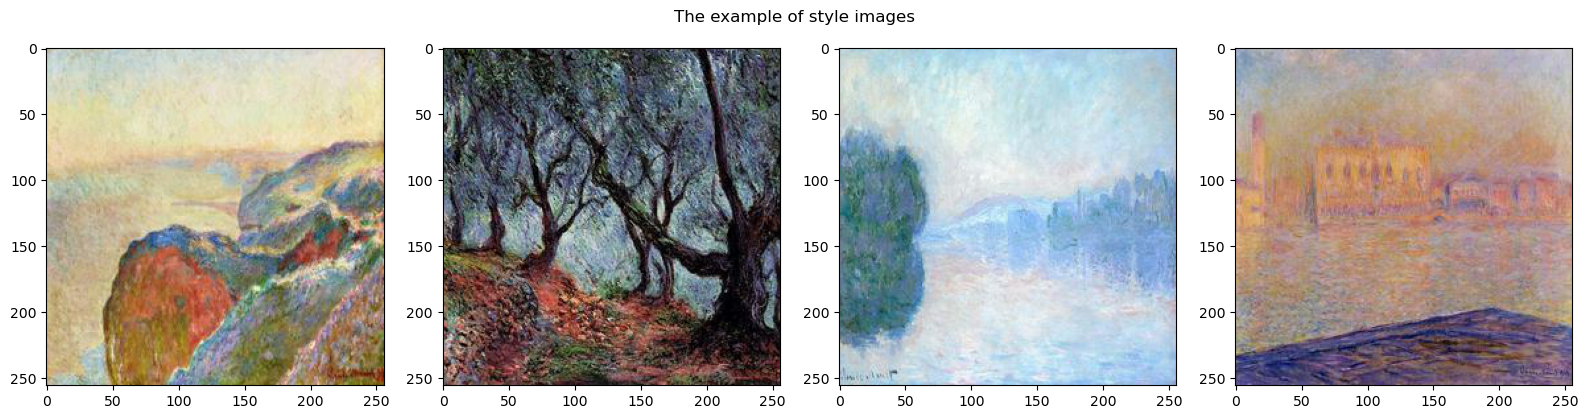

In [80]:
rows = 1
cols = 4

plot_images_from_dataset(style_dataset, rows, cols, 'The example of style images')

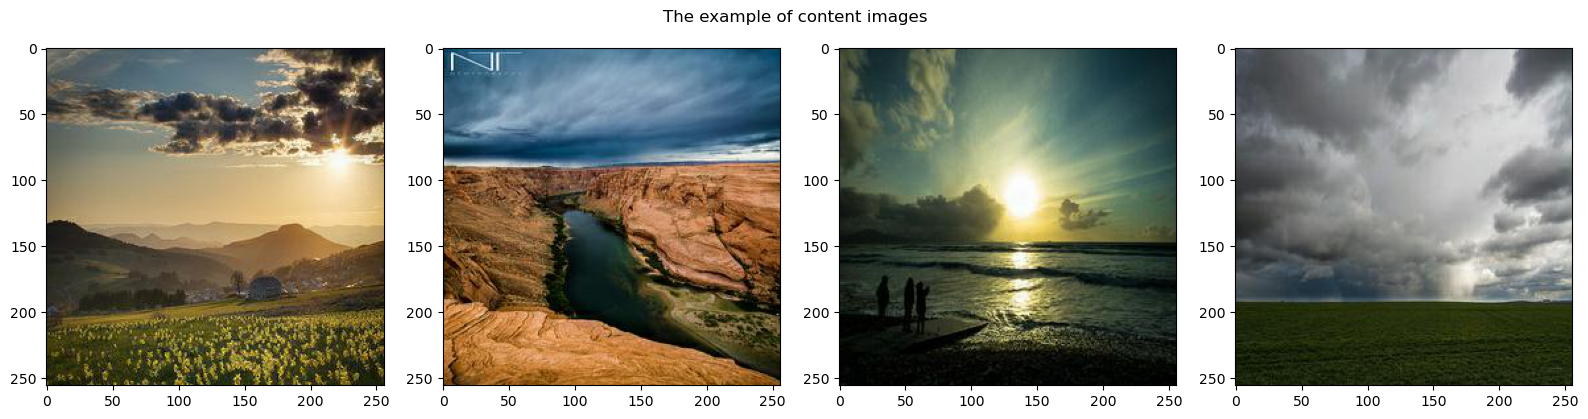

In [81]:
rows = 1
cols = 4

plot_images_from_dataset(content_dataset, rows, cols, 'The example of content images')

In [71]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # The first number x in convx_y gets added by 1 after it has gone
        # through a maxpool, and the second y if we have several conv layers
        # in between a max pool. These strings (0, 5, 10, ..) then correspond
        # to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 mentioned in NST paper
        self.chosen_features = ["0", "5", "10", "19", "28"]

        # We don't need to run anything further than conv5_1 (the 28th module in vgg)
        # Since remember, we dont actually care about the output of VGG: the only thing
        # that is modified is the generated image (i.e, the input).
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        # Go through each layer in model, if the layer is in the chosen_features,
        # store it in features. At the end we'll just return all the activations
        # for the specific layers we have in chosen_features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

In [70]:
def load_images(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [82]:
model = VGG().to(device).eval()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\melni/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:58<00:00, 4.86MB/s] 


In [188]:
device

device(type='cpu')

In [180]:
# original_img = load_image("annahathaway.png")
# style_img = load_image("style.jpg")

# # initialized generated as white noise or clone of original image.
# # Clone seemed to work better for me.

# # generated = torch.randn(original_img.data.shape, device=device, requires_grad=True)
# generated = original_img.clone().requires_grad_(True)


# Hyperparameters
total_steps = 6000
learning_rate = 0.001
EPOCHS = 2
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

In [187]:
for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        # save_image(generated, "generated.png")

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1258291200 bytes.